In [10]:
import urllib.request
import pandas as pd
import json
import numpy as np
import datetime
import time
import os

# Configuration of the API to obtain the data
url = "https://min-api.cryptocompare.com/data/histominute"
currency = "USD"
APP_NAME = "nw_crypto_sentiment_2022"

# Symbol and data limit of the API
symbol = 'BTC'
print(symbol)
limit = 2000

# Paths and rules to create the files
path = f"../data/crypto/{symbol}"
character = '~'
cols = ['CRYPTO', 'MOST_RECENT_FILE', 'MOST_RECENT_FILE_LINE_COUNT', 'MOST_RECENT_TS']
max_rows = 10000

BTC


In [11]:
# Function to get data. Inputs data to return, limit in minutes, and crypto symbol ('BTC' for example)
def get_data_minutely(toTs, limit, symbol):
    contents = urllib.request.urlopen(
        f"{url}?fsym={symbol}&tsym={currency}&limit={limit}&toTs={toTs}&extraParams={APP_NAME}"
    ).read()
    json_string = contents.decode("utf-8")
    obj = json.loads(json_string)
    df = pd.DataFrame.from_dict(obj['Data'])
    if not df.empty:
        return df.drop(['volumefrom', 'volumeto'], axis=1)
    return df

def get_var(key, crypto):
    df_var = pd.read_csv("../data/crypto/var_crypto.csv", sep = ',',
                         dtype = {'MOST_RECENT_TS': np.int32, 'MOST_RECENT_FILE_LINE_COUNT': np.int32})
    return df_var[key].loc[df_var['CRYPTO'] == crypto].values[0]

def update_var(key, value, crypto):
    df_var = pd.read_csv("../data/crypto/var_crypto.csv", sep = ',',
                         dtype = {'MOST_RECENT_TS': np.int32, 'MOST_RECENT_FILE_LINE_COUNT': np.int32})
    df_var[key].loc[df_var['CRYPTO'] == crypto] = str(value)
    df_var.to_csv("../data/crypto/var_crypto.csv", index=False)
    
def add_new_crypto(crypto):
    df_var = pd.read_csv("../data/crypto/var_crypto.csv", sep = ',',
                         dtype = {'MOST_RECENT_TS': np.int32, 'MOST_RECENT_FILE_LINE_COUNT': np.int32})
    if df_var[cols[0]].loc[df_var['CRYPTO'] == crypto].empty:
        new_line = pd.DataFrame([[crypto,-1,"",0]], columns=cols)
        df_var = df_var.append(new_line)
        df_var.to_csv("../data/crypto/var_crypto.csv", index=False)

In [12]:
add_new_crypto(symbol)

In [13]:
df_histo = get_data_minutely(1641926708, 10, symbol)
print(df_histo['time'].iloc[-1])
print(datetime.datetime.fromtimestamp(int(df_histo['time'].iloc[0])).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.datetime.fromtimestamp(int(df_histo['time'].iloc[-1])).strftime('%Y-%m-%d %H:%M:%S'))
print(df_histo.shape)
df_histo.head(3)

1641926700
2022-01-11 11:35:00
2022-01-11 11:45:00
(11, 7)


,time,high,low,open,close,conversionType,conversionSymbol
0,1641926100,42804.27,42705.56,42705.82,42802.23,direct,
1,1641926160,42840.62,42788.15,42802.23,42840.62,direct,
2,1641926220,42862.99,42819.03,42840.62,42821.27,direct,


In [14]:
# Number of objects that are going to be retrieved by the API
# Seven days, but by minute, seven times 24 times 7 (API Limit)
total_wished = 60 * 24 * 7

# Last timestamp to return from, if minus 1 gets the most recent
# toTs = -1
toTs = 1641926708

# History data frame object
df_historical = pd.DataFrame()

# Get the recent file if it exists
# Use the file to store data there
last_times = get_var(cols[3], symbol)
last_file_line_count = 0
last_file = None
if last_times > 0:
    last_file = get_var(cols[1], symbol)
    last_file_line_count = get_var(cols[2], symbol)
    now = int(time.time())
    total_wished = int((now - last_times)/60)

# Data from 7 days until the last timestamp
while(total_wished > 0):
    limit = min(total_wished, limit)
    df = get_data_minutely(toTs, limit, symbol)
    if df.empty:
        print(df.shape)
        break
    df_historical = df_historical.append(df)
    min_time = df['time'].iloc[0]
    max_time = df['time'].iloc[-1]
    print('range=', datetime.datetime.fromtimestamp(min_time).strftime('%Y-%m-%d %H:%M:%S'),
         datetime.datetime.fromtimestamp(max_time).strftime('%Y-%m-%d %H:%M:%S'))
    toTs = min_time
    total_wished = total_wished - df.shape[0]

# Ascending sorting of data timestamps
if not df_historical.empty:

    df_historical = df_historical.sort_values(by=['time'])

    print(last_file_line_count)
    # Save to CSV file
    available_lines = max_rows - last_file_line_count
    df_to_fulfill = df_historical.head(available_lines)
    df_remaining  = df_historical.tail(df_historical.shape[0] - df_to_fulfill.shape[0])

    print('df_to_fulfill', df_to_fulfill.shape)
    print('df_remaining', df_remaining.shape)

    # Fulfill last file if any
    if not df_to_fulfill.empty:
        from_str = datetime.datetime.fromtimestamp(df_to_fulfill['time'].iloc[0]).strftime('%Y-%m-%d %H-%M-%S')
        max_time = df_to_fulfill['time'].iloc[-1]
        to_str = datetime.datetime.fromtimestamp(max_time).strftime('%Y-%m-%d %H-%M-%S')
        if last_file is None:
            last_file = f"{path}/{from_str}{character}{to_str}.csv"
            df_to_fulfill.to_csv(last_file, mode='w', header=True, index=False)
        else:
            df_to_fulfill.to_csv(last_file, mode='a', header=False, index=False)
            filename = f"{last_file.split(character)[0]}{character}{to_str}.csv"
            os.rename(last_file, filename)
        last_file_line_count = last_file_line_count + df_to_fulfill.shape[0]
        
    # Split
    list_df_remaining = [df_remaining[i:i+max_rows] for i in range(0, df_remaining.shape[0], max_rows)]
    for df_remain in list_df_remaining:
        from_str = datetime.datetime.fromtimestamp(df_remain['time'].iloc[0]).strftime('%Y-%m-%d %H-%M-%S')
        max_time = df_remain['time'].iloc[-1]
        to_str = datetime.datetime.fromtimestamp(max_time).strftime('%Y-%m-%d %H-%M-%S')
        filename = f"{path}/{from_str}{character}{to_str}.csv"
        df_remain.to_csv(filename, index = False)
        last_file_line_count = df_remain.shape[0]

    # Change variables in environment file
    update_var(cols[3], max_time, symbol)
    update_var(cols[1], filename, symbol)
    update_var(cols[2], last_file_line_count, symbol)

print('done')

range= 2022-01-11 09:38:00 2022-01-11 11:45:00
2490
df_to_fulfill (128, 7)
df_remaining (0, 7)
done


/Users/aguerrero023/opt/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import glob

max_rw = 500 # Plot the max_rw most recent points

In [16]:
# Dataframe that has the number of rows of the data
def get_most_recent_data_from_csv(folder, n_rows):
    files =  glob.glob(f"{folder}/*.csv")
    files = sorted(files)
    df = pd.DataFrame()
    for file in reversed(files):
        print(file)
        df = df.append(pd.read_csv(file))
        if df.shape[0] > n_rows:
            break
    return df.sort_values(by=['time']).tail(n_rows)

In [17]:
# Get the rows maximum
df_hist_minutes = get_most_recent_data_from_csv(path, max_rw)
print('df shape', df_hist_minutes.shape)
from_str = datetime.datetime.fromtimestamp(df_hist_minutes['time'].iloc[0]).strftime('%Y-%m-%d %H-%M-%S')
to_str = datetime.datetime.fromtimestamp(df_hist_minutes['time'].iloc[-1]).strftime('%Y-%m-%d %H-%M-%S')
print('from', from_str, 'to', to_str)
df = df_hist_minutes
df['time'] = df_hist_minutes['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df.head(5)

../data/crypto/BTC/2022-01-10 17-22-00~2022-01-11 11-45-00.csv
df shape (500, 7)
from 2022-01-12 02-29-00 to 2022-01-12 10-45-00


,time,high,low,open,close,conversionType,conversionSymbol
1990,2022-01-12 02:29:00,42905.14,42883.81,42887.65,42895.24,direct,NaN
1991,2022-01-12 02:30:00,42901.51,42881.96,42895.24,42888.44,direct,NaN
1992,2022-01-12 02:31:00,42888.76,42863.75,42888.44,42863.75,direct,NaN
1993,2022-01-12 02:32:00,42863.75,42836.20,42863.75,42852.38,direct,NaN
1994,2022-01-12 02:33:00,42861.69,42846.01,42852.38,42846.01,direct,NaN


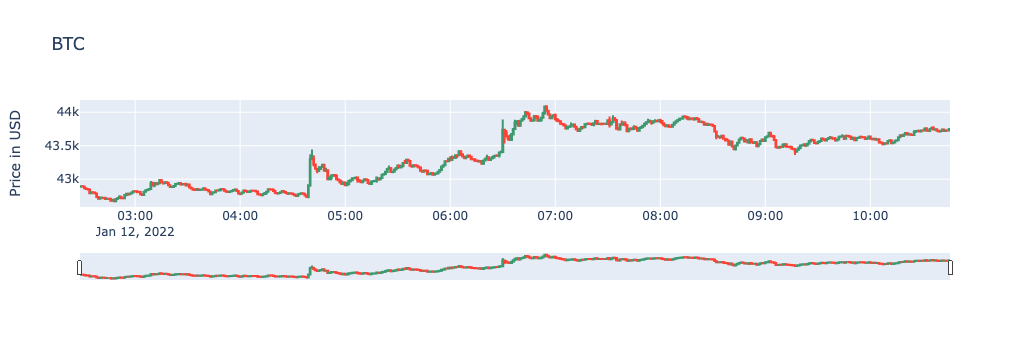

In [18]:
# Plot prices of crypto
trace = go.Candlestick(x = df.time, open = df.open, high = df.high, low = df.low, close = df.close)
data = [trace]
layout = {
    'title': f"{symbol}",
    'yaxis': {'title': 'Price in USD'},
}
fig = dict(data = data, layout = layout)
iplot(fig)